In [1]:
using Gen
using Plots
using DelimitedFiles

In [23]:
# helper function
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end;

# "Musical notes" example

We have 5 musical notes; a composition is defined by a set of stochastic transitions between notes. 

With probability 0.6 we stay on the current note; with probability 0.1, we transition to a new note.

Let's start with writing a generative model of such simple compositions. 

In [2]:
# helper functions to write the generative model
#

function transition_prob(a, b)
    a == b ? 0.6 : 0.1
end

# setup transition probabilities
function transition_prob_matrix()
    note_transitions = Array{Float64}(undef, 5, 5)
    for i=1:5
        [note_transitions[i, j] = transition_prob(i,j) for j=1:5]
    end
    return note_transitions
end

# make this variable global (makes some of the coding more straightforward)
global note_transitions = transition_prob_matrix()

5×5 Matrix{Float64}:
 0.6  0.1  0.1  0.1  0.1
 0.1  0.6  0.1  0.1  0.1
 0.1  0.1  0.6  0.1  0.1
 0.1  0.1  0.1  0.6  0.1
 0.1  0.1  0.1  0.1  0.6

Now, we can use this transition probabilities to actually define our generative model of compositions.

Notice that our observation space is a bit idiosyncratic. We assume that when a note is played, we observe a vector of a few real numbers, sampled from a Gaussian distribution. In a more realistic example, we would project each note to a [spectogram](https://musiclab.chromeexperiments.com/spectrogram/). 

In [7]:
@gen function musical_notes(K::Int)
    # sample an initial "note"
    current_note = {:notes => 1 => :θ} ~ uniform_discrete(1, 5)
    
    # "play" it: projecting it to "auditory features" of length 3
    note_play_length = 3
    mu = current_note * 0.1
    {:data => 1 => :y} ~ broadcasted_normal(repeat([mu], note_play_length), repeat([0.05], note_play_length))

    # keep going for K notes
    for k=1:K
        current_note = {:notes => k+1 => :θ} ~ categorical(note_transitions[current_note, :])
        mu = current_note * 0.1
        {:data => k+1 => :y} ~ broadcasted_normal(repeat([mu], note_play_length), repeat([0.05], note_play_length))
    end 
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64], false, Union{Nothing, Some{Any}}[nothing], var"##musical_notes#229", Bool[0], false)

In [8]:
trace = simulate(musical_notes, (10,))
get_choices(trace)

│
├── :notes
│   │
│   ├── 5
│   │   │
│   │   └── :θ : 5
│   │
│   ├── 8
│   │   │
│   │   └── :θ : 5
│   │
│   ├── 1
│   │   │
│   │   └── :θ : 3
│   │
│   ├── 6
│   │   │
│   │   └── :θ : 5
│   │
│   ├── 11
│   │   │
│   │   └── :θ : 1
│   │
│   ├── 9
│   │   │
│   │   └── :θ : 2
│   │
│   ├── 3
│   │   │
│   │   └── :θ : 4
│   │
│   ├── 7
│   │   │
│   │   └── :θ : 5
│   │
│   ├── 4
│   │   │
│   │   └── :θ : 3
│   │
│   ├── 2
│   │   │
│   │   └── :θ : 4
│   │
│   └── 10
│       │
│       └── :θ : 4
│
└── :data
    │
    ├── 5
    │   │
    │   └── :y : [0.5573084524538565, 0.5603579993217913, 0.5576705051969008]
    │
    ├── 8
    │   │
    │   └── :y : [0.48412312303099087, 0.4497438266222504, 0.45260918086156554]
    │
    ├── 1
    │   │
    │   └── :y : [0.20308721128681537, 0.3400567062076529, 0.4197013440939992]
    │
    ├── 6
    │   │
    │   └── :y : [0.3653966319037359, 0.593703624253123, 0.4816212496706526]
    │
    ├── 11
    │   │
    │   └── :y : [0.0659119780414

In [14]:
notes = Vector{Int}[]
features = Vector{Float64}[]
[push!(notes, [trace[:notes => k => :θ]]) for k=1:10]
[push!(features, trace[:data => k => :y]) for k=1:10]

10-element Vector{Vector{Vector{Float64}}}:
 [[0.20308721128681537, 0.3400567062076529, 0.4197013440939992], [0.3943281415592681, 0.4429591645953209, 0.34950890110077787], [0.2708299434653657, 0.3967052363742782, 0.34005391914243516], [0.3243740949643421, 0.25428572770977925, 0.2897690959583866], [0.5573084524538565, 0.5603579993217913, 0.5576705051969008], [0.3653966319037359, 0.593703624253123, 0.4816212496706526], [0.5734158667160645, 0.46336339417481787, 0.4556552186347871], [0.48412312303099087, 0.4497438266222504, 0.45260918086156554], [0.17961761547520688, 0.32173006602112264, 0.2387741636218619], [0.34855893009640665, 0.37080672704813056, 0.3085102285741956]]
 [[0.20308721128681537, 0.3400567062076529, 0.4197013440939992], [0.3943281415592681, 0.4429591645953209, 0.34950890110077787], [0.2708299434653657, 0.3967052363742782, 0.34005391914243516], [0.3243740949643421, 0.25428572770977925, 0.2897690959583866], [0.5573084524538565, 0.5603579993217913, 0.5576705051969008], [0.36539

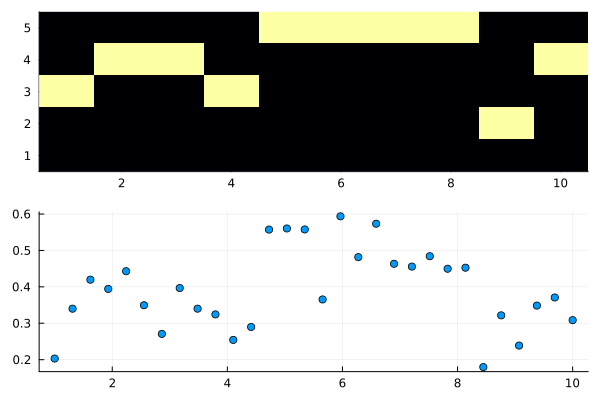

In [15]:
function visualize_notes(notes, features)
    K = length(notes)
    binary_notes = zeros(Int, 5, K)
    for k = 1:K
        binary_notes[notes[k][1], k] = 1
    end

    # plot the notes played
    p1 = plot(binary_notes, seriestype=:heatmap, legend=:none)

    # plot "audio"
    features = collect(Iterators.flatten(transpose(features)))
    p2 = plot(collect(range(1, K, length=length(features))), features, seriestype=:scatter)
    plot(p1, p2, layout=(2,1), legend=false)
end
visualize_notes(notes, features)

### code to save synthesized data -- 
# features_matrix = reduce(hcat, features)'
# writedlm("notes_observe_new.txt", features_matrix, ",")

In [18]:
function particle_filter(num_particles::Int, zs::Matrix{Float64}, num_samples::Int)

    #initital observation
    init_obs = Gen.choicemap((:data => 1 => :y, zs[1, :]))
    
    # initialize the particle filter (Step 0) -- 
    # sampling from the prior and weighting by the likelihood
    state = Gen.initialize_particle_filter(musical_notes, (0,), init_obs, num_particles)
    
    for k=1:size(zs)[1]-1
        # Evolve and resample (Step 1a, 1b)
        maybe_resample!(state, ess_threshold=num_particles/2)
        # load observations of this time step
        obs = Gen.choicemap((:data => k+1 => :y, zs[k+1,:]))
        # Re-weight by the likelihood (Step 2)
        Gen.particle_filter_step!(state, (k,), (UnknownChange(),), obs)
    end
    
    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end

particle_filter (generic function with 1 method)

In [20]:
# load observations (sensory features)
zs = readdlm("notes_observe.txt", ',')
# run particle filter with 1000 particles, 
# and return 100 unweighted posterior samples
pf_traces = particle_filter(1000, zs, 100);

In [21]:
# a polymorphic visualization function when the notes is a matrix already
function visualize_notes(notes::Matrix{Float64}, features)
    K = size(notes)[2]
    p1 = plot(notes, seriestype=:heatmap)
    features = collect(Iterators.flatten(transpose(features)))
    p2 = plot(collect(range(1, K, length=length(features))), features, seriestype=:scatter)
    plot(p1, p2, layout=(2,1), legend=false)
end

visualize_notes (generic function with 2 methods)

Log probability: 35.82438363317915


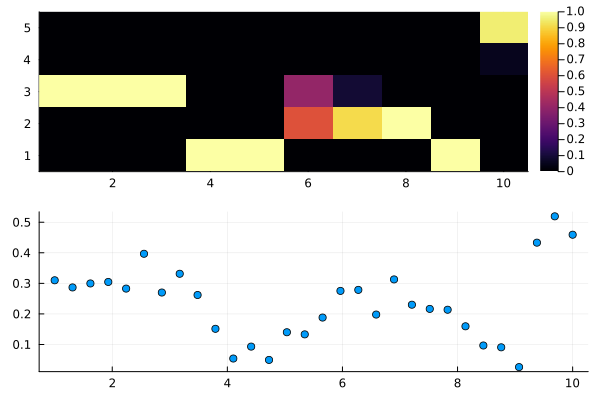

In [24]:
scores = Vector{Float64}(undef, 100)
inferred_notes = zeros(Int, 100, 10)
aggregate_notes_matrix = zeros(Float64, 5, 10)
for i=1:100
    tr = pf_traces[i]
    scores[i] = get_score(tr)
    for k = 1:size(zs)[1]
        inferred_notes[i, k] = tr[:notes => k => :θ]
        aggregate_notes_matrix[inferred_notes[i, k], k] += 1.0
    end
end

aggregate_notes_matrix = aggregate_notes_matrix ./ 100
println("Log probability: ", logmeanexp(scores))
visualize_notes(aggregate_notes_matrix, zs)

## Combinators: Map

For loop can be slow. Can we get accelerate the inference?
Let's first revisit  `unknown_urn` generative model for a moment.

In [27]:
@gen function unknown_urn()
    # p(θ) ̃Uniform(0,1)  [prior distribution]
    theta ~ uniform(0, 1)
    for i=1:100
        # p(y=1|θ) ~ Bernoulli(θ) [likelihood function]
        {:data => i => :y} ~ bernoulli(theta)
    end
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##unknown_urn#279", Bool[], false)

Let's start with writing the kernel for this loop

In [21]:
# kernel generative function G_k
@gen (static) function unknown_urn_flip_kernel(theta::Float64)
    # p(y|θ) ~ Bernoulli(θ) [likelihood function]
    y ~ bernoulli(theta)
    return y
end

var"##StaticGenFunction_unknown_urn_flip_kernel#242"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

Now let's loop this within a static version of our unknown generative model

In [22]:
@gen (static) function unknown_urn_static(k::Int64)
    # prior over coin weight p(θ)
    theta ~ uniform(0,1)
    # called k times
    data ~ Gen.Map(unknown_urn_flip_kernel)(fill(theta, k))
end

var"##StaticGenFunction_unknown_urn_static#266"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [36]:
# # need this to load the static functions (not necessary for more recent version)
# @load_generated_functions

# get a draw and peek inside
(trace, _) = generate(unknown_urn_static, (3,))
get_choices(trace)

│
├── :theta : 0.48592872586107905
│
└── :data
    │
    ├── 1
    │   │
    │   └── :y : false
    │
    ├── 2
    │   │
    │   └── :y : true
    │
    └── 3
        │
        └── :y : false


### An additional `Map` example with multiple arguments

In [24]:
# this is our kernel G_k
@gen function noisy_sum_kernel(x1::Float64, x2::Float64)
    # draw a normal based on the arguments 
    y = @trace(normal(x1 + x2, 1.0), :z)
    # and return it
    return y
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Float64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##noisy_sum_kernel#278", Bool[0, 0], false)

In [25]:
# a new generative function using the Map combinator
noisy_sum = Map(noisy_sum_kernel)

Map{Any, Gen.DynamicDSLTrace}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Float64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##noisy_sum_kernel#278", Bool[0, 0], false))

In [26]:
# need this to load the static functions
@load_generated_functions

(trace, _) = generate(noisy_sum, ([0.0, 0.5], [0.5, 1.0]))
get_choices(trace)

┌ Warning: `Gen.@load_generated_functions` is no longer necessary and will be removed in a future release.
└ @ Gen ~/.julia/packages/Gen/ME5el/src/Gen.jl:33


│
├── 1
│   │
│   └── :z : 0.8482250075496671
│
└── 2
    │
    └── :z : 2.0886613466166604


## The Unfold combinator for our musical note example

In [14]:
@gen function musical_notes_kernel(k::Int, prev_note)
    # draw the note
    current_note = {:θ} ~ categorical(note_transitions[prev_note, :])

    # how long it takes to play a note
    note_play_length = 3
    # draw the sensory features
    mu = current_note * 0.1
    {:y} ~ broadcasted_normal(repeat([mu], note_play_length), repeat([0.05], note_play_length))
    
    #return the current note for recursion
    return current_note
end

@gen function unfold_musical_notes(K::Int)    
    # sample an initial "note"
    init_note = uniform_discrete(1, 5)

    # call the temporal kernel and unfold it for K time steps
    music ~ Unfold(musical_notes_kernel)(K, init_note)

end

trace = simulate(unfold_musical_notes, (10,))
get_choices(trace)
notes = Vector{Int}[]
features = Vector{Float64}[]
[push!(notes, [trace[:music => k => :θ]]) for k=1:10]
[push!(features, trace[:music => k => :y]) for k=1:10]

10-element Vector{Vector{Vector{Float64}}}:
 [[0.361960278480589, 0.27664027296589205, 0.23884498994423156], [0.5299238634171954, 0.4020003684736302, 0.3856937802671748], [0.363636470673617, 0.4254443019065785, 0.3517456489138683], [0.4137764702319859, 0.371736261242933, 0.4667930690742954], [0.4760088709354909, 0.35493906687609045, 0.37882923944461533], [0.37798193612250486, 0.5043717504367808, 0.30360811721040787], [0.09769639270124017, 0.09209072834322442, 0.005927087639377035], [0.13065406121535614, 0.0963465048988728, 0.09478125173812374], [0.17313015055337777, 0.11907203726810661, 0.05548348677464001], [0.07682657305245907, 0.03863272063426677, 0.06454881490095415]]
 [[0.361960278480589, 0.27664027296589205, 0.23884498994423156], [0.5299238634171954, 0.4020003684736302, 0.3856937802671748], [0.363636470673617, 0.4254443019065785, 0.3517456489138683], [0.4137764702319859, 0.371736261242933, 0.4667930690742954], [0.4760088709354909, 0.35493906687609045, 0.37882923944461533], [0.377

### With the (static) annotation

In [16]:
@gen (static) function musical_notes_kernel(k::Int, prev_note)
    # draw the note
    current_note = {:θ} ~ categorical(note_transitions[prev_note, :])

    # how long it takes to play a note
    note_play_length = 3
    # draw the sensory features
    mu = current_note * 0.1
    {:y} ~ broadcasted_normal(repeat([mu], note_play_length), repeat([0.05], note_play_length))
    
    #return the current note for recursion
    return current_note
end

@gen (static) function unfold_musical_notes(K::Int)    
    # sample an initial "note"
    init_note = uniform_discrete(1, 5)

    # call the temporal kernel and unfold it for K time steps
    music ~ Unfold(musical_notes_kernel)(K, init_note)

end

trace = simulate(unfold_musical_notes, (10,))
get_choices(trace)
notes = Vector{Int}[]
features = Vector{Float64}[]
[push!(notes, [trace[:music => k => :θ]]) for k=1:10]
[push!(features, trace[:music => k => :y]) for k=1:10]

10-element Vector{Vector{Vector{Float64}}}:
 [[0.05486289210849907, 0.1059793397649005, 0.12780876470425334], [0.434312861562516, 0.41812709706456225, 0.38721812148925217], [0.14465106912343, 0.05607753402730889, 0.1122036861841397], [0.1453936678390706, 0.11984189361278454, 0.2137089596229109], [0.025283530925951772, 0.21325032686116963, 0.1987386971936641], [0.11403385471798605, 0.08816144360970593, 0.11823219457079248], [0.11513862559856956, 0.08220943641150336, 0.14246361995032616], [0.4315979400130261, 0.5086167112674245, 0.4791443063944461], [0.09621707052109049, 0.13908472889469484, 0.07378088164747046], [0.07861008172061898, 0.09128056441714305, 0.05785422203320916]]
 [[0.05486289210849907, 0.1059793397649005, 0.12780876470425334], [0.434312861562516, 0.41812709706456225, 0.38721812148925217], [0.14465106912343, 0.05607753402730889, 0.1122036861841397], [0.1453936678390706, 0.11984189361278454, 0.2137089596229109], [0.025283530925951772, 0.21325032686116963, 0.1987386971936641]

In [17]:
function particle_filter_with_unfold(num_particles::Int, zs::Matrix{Float64}, num_samples::Int)

    #initital observation
    init_obs = Gen.choicemap((:music => 0 => :y, zs[1, :]))
    
    # initialize the particle filter (Step 0) -- 
    # sampling from the prior and weighting by the likelihood
    state = Gen.initialize_particle_filter(unfold_musical_notes, (0,), init_obs, num_particles)
    
    for k=1:size(zs)[1]
        # Evolve and resample (Step 1a, 1b)
        maybe_resample!(state, ess_threshold=num_particles/2)
        # load observations of this time step
        obs = Gen.choicemap((:music => k => :y, zs[k,:]))
        # Re-weight by the likelihood (Step 2)
        Gen.particle_filter_step!(state, (k,), (UnknownChange(),), obs)
    end
    
    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end

particle_filter_with_unfold (generic function with 1 method)

Log probability: 36.72175441366633


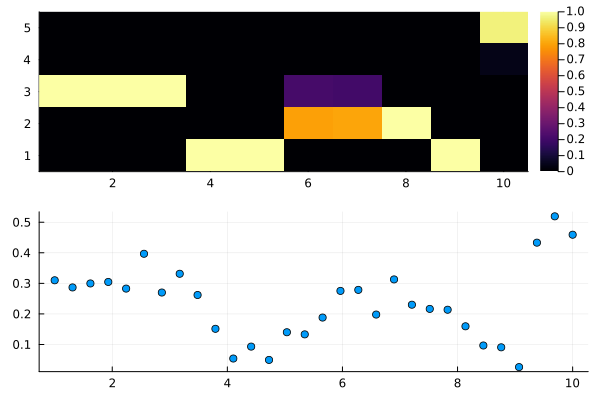

In [32]:
# load observations (sensory features)
zs = readdlm("notes_observe.txt", ',')
# run particle filter with 1000 particles, 
# and return 100 unweighted posterior samples
pf_traces = particle_filter_with_unfold(1000, zs, 100);

scores = Vector{Float64}(undef, 100)
inferred_notes = zeros(Int, 100, 10)
aggregate_notes_matrix = zeros(Float64, 5, 10)
for i=1:100
    tr = pf_traces[i]
    scores[i] = get_score(tr)
    for k = 1:size(zs)[1]
        inferred_notes[i, k] = tr[:music => k => :θ]
        aggregate_notes_matrix[inferred_notes[i, k], k] += 1.0
    end
end

aggregate_notes_matrix = aggregate_notes_matrix ./ 100
println("Log probability: ", logmeanexp(scores))
visualize_notes(aggregate_notes_matrix, zs)

### Time comparison of non-unfold and unfold generative models

In [24]:
# test both generative models for increasingly longer sequences
for K=10:30
    # generate fake data
    trace = simulate(unfold_musical_notes, (K,))
    zs = Array{Float64}(undef, K, 3)
    [zs[k,:] = trace[:music => k => :y] for k=1:K]

    # inference with unfold based static gm
    @time particle_filter_with_unfold(1000, zs, 100)    
end

  0.212010 seconds (1.40 M allocations: 96.100 MiB, 26.90% gc time)
  0.181091 seconds (1.53 M allocations: 106.052 MiB, 17.74% gc time)
  0.199166 seconds (1.67 M allocations: 116.211 MiB, 10.75% gc time)
  0.178509 seconds (1.80 M allocations: 126.429 MiB)
  0.255829 seconds (1.94 M allocations: 137.039 MiB, 7.93% gc time)
  0.268262 seconds (2.07 M allocations: 147.540 MiB, 8.63% gc time)
  0.290940 seconds (2.21 M allocations: 158.248 MiB, 7.12% gc time)
  0.252676 seconds (2.34 M allocations: 169.132 MiB, 8.63% gc time)
  0.297692 seconds (2.48 M allocations: 180.154 MiB, 13.62% gc time)
  0.294334 seconds (2.62 M allocations: 191.027 MiB, 6.15% gc time)
  0.332496 seconds (2.75 M allocations: 202.308 MiB, 6.68% gc time)
  0.355684 seconds (2.89 M allocations: 213.657 MiB, 11.63% gc time)
  0.371295 seconds (3.02 M allocations: 225.143 MiB, 5.86% gc time)
  0.433432 seconds (3.16 M allocations: 236.643 MiB, 10.75% gc time)
  0.394131 seconds (3.29 M allocations: 248.443 MiB, 5.40%

In [23]:
# test both generative models for increasingly longer sequences
for K=10:30
    # generate fake data
    trace = simulate(unfold_musical_notes, (K,))
    zs = Array{Float64}(undef, K, 3)
    [zs[k,:] = trace[:music => k => :y] for k=1:K]

    # # inferencew with DML based gm
    @time particle_filter(1000, zs, 100)
end

  1.061129 seconds (7.95 M allocations: 505.549 MiB, 43.87% gc time)
  1.132377 seconds (9.57 M allocations: 608.880 MiB, 34.98% gc time)
  1.772438 seconds (11.34 M allocations: 720.202 MiB, 51.80% gc time)
  1.764492 seconds (13.24 M allocations: 840.005 MiB, 42.75% gc time)
  1.781908 seconds (15.28 M allocations: 967.801 MiB, 32.18% gc time)
  2.391841 seconds (17.46 M allocations: 1.078 GiB, 44.48% gc time)
  2.484812 seconds (19.77 M allocations: 1.219 GiB, 37.68% gc time)
  2.714673 seconds (22.23 M allocations: 1.368 GiB, 36.85% gc time)
  3.416379 seconds (24.83 M allocations: 1.525 GiB, 43.72% gc time)
  3.586414 seconds (27.56 M allocations: 1.690 GiB, 39.57% gc time)
  4.418381 seconds (30.44 M allocations: 1.863 GiB, 46.44% gc time)
  4.243229 seconds (33.45 M allocations: 2.044 GiB, 36.13% gc time)
  5.001303 seconds (36.60 M allocations: 2.233 GiB, 42.43% gc time)
  5.060083 seconds (39.89 M allocations: 2.430 GiB, 34.27% gc time)
  5.531252 seconds (43.32 M allocations: